In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import time
import qcodes as qc
from qcodes.loops import Loop
import qcodes.instrument_drivers

import Agilent_33500B as keysource

import logging
import ctypes
import time
timestr = time.strftime("%Y%m%d_%H%M%S")
# logging.basicConfig(filename='example.log',level=logging.INFO)


import Holzworth_Final as holz

import LeCroy_16bit


#qc.halt_bg()



C:\Users\user\Anaconda3\envs\qcodes\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lcr = LeCroy_16bit.LCR('lcr3','USB0::0x05FF::0x1023::3515N50694::INSTR')

Connected to: LECROY HDO4054A (serial:LCRY3515N50694, firmware:8.5.0) in 0.10s


In [3]:
gate_9=keysource.Agilent_33500B('gate', 'GPIB0::14::INSTR', channel=1) #RF TRI

Connected to: Agilent Technologies 33522B (serial:MY52814732, firmware:3.05-1.19-2.00-52-00) in 0.09s


In [4]:
# set limits for remotely setting sweep range for each measurement
gate_9.offset.set_step(0.02) 
gate_9.offset.set_delay(0.3) 
gate_9.amplitude.set_step(0.005) 
gate_9.amplitude.set_delay(0.3) 

In [ ]:
Holz = holz.HS9004A(name = 'Holz')

In [ ]:
Holz.ch3_pwr(-20) #RF, with additional 20dB ta output and 50dB in fridge
Holz.ch4_pwr(0.2) #LO

In [ ]:
Holz.ch3_freq(624)
Holz.ch4_freq(624)

In [ ]:
Holz.ch3_output(1)
Holz.ch4_output(1)

# Reflectometry
Instructions
* connect output I and Q of SR560 to CH1 and CH3 repsectively
* connect sync of AWG to any other channel for triggering
* set rf freq and averages and start & end of the sweep correctly
* DC offset for I and Q can be defined to calculate the exact phase when operating at AC coupling (default value is 1 makiing the phase close to 45 deg)
* On screen choose timebase manually that RF up sweep fits (make high value of trigger fit) and that sweep up starts with first sample (which is the positive edge of trigger), recorded data is then cut accordingly afterwards in the driver using the earlier specified frequency
* run prepare curvedata afterwards (this needs to be re-run every time the timebase or number of samples is changed on the oscilloscope)
* the setup_awg functions sets the specified gate sweep on the AWG remotely (this can be skipped and done manually) 
* Acquire curvedata

In [5]:
lcr.reflectometry.frequency(83)

In [6]:
lcr.reflectometry.start(0.4)
lcr.reflectometry.end(0.5)

In [7]:
lcr.reflectometry.I_DC(1.)
lcr.reflectometry.Q_DC(1.)

In [8]:
lcr.reflectometry.average(100)

In [9]:
lcr.clear_message_queue() #sometimes when somethign goes wrong you need to clear the data queue first, otherwise you will get errors

In [9]:
lcr.reflectometry.curvedata.prepare_curvedata() # 
lcr.reflectometry.setup_AWG(gate_9) # make sure limits are set! This is optional and can be done manually

In [8]:
data=qc.Measure(lcr.reflectometry.curvedata).run(name='test')

DataSet:
   location = 'data/2018-01-22/#018_{name}_23-46-39'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | Sweep_set                    | Sweep        | (60240,)
   Measured | lcr3_reflectometry_I         | I            | (60240,)
   Measured | lcr3_reflectometry_Q         | Q            | (60240,)
   Measured | lcr3_reflectometry_magnitude | magnitude    | (60240,)
   Measured | lcr3_reflectometry_phase     | phase        | (60240,)
acquired at 2018-01-22 23:46:43


<IPython.core.display.Javascript object>


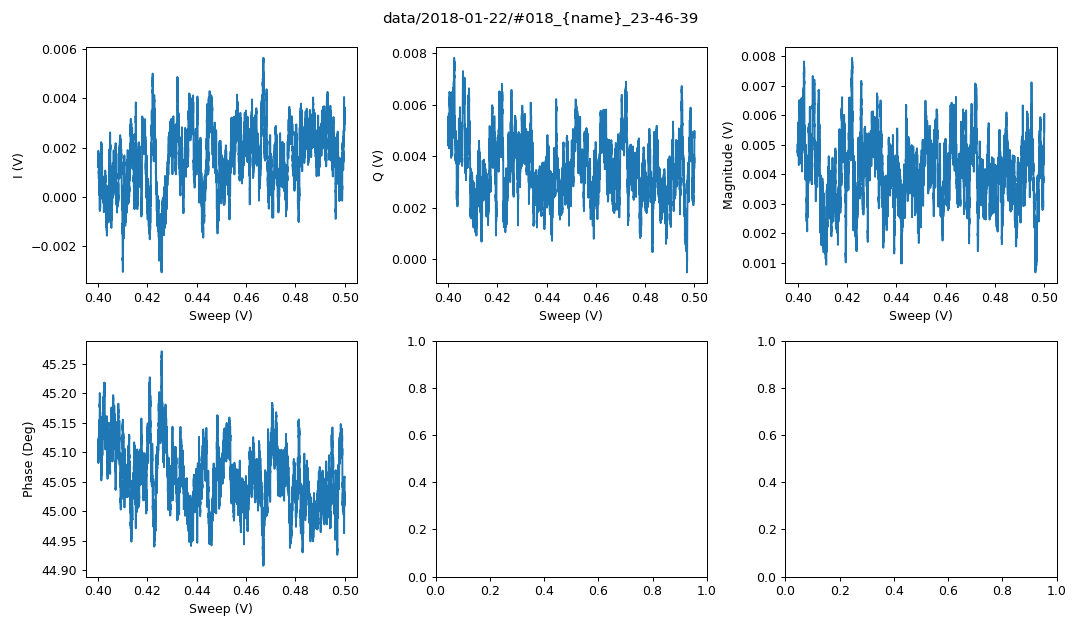

In [9]:
qc.MatPlot(data.lcr3_reflectometry_I, data.lcr3_reflectometry_Q, data.lcr3_reflectometry_magnitude, data.lcr3_reflectometry_phase,subplots=(2,2))

# Use the Oscilloscope to get time based channel data
Instructions
* You san also use the driver as follows to acquire any channel data as a function of time

45.0

In [8]:
lcr.ask('*IDN?')

'LECROY,HDO4054A,LCRY3515N50694,8.5.0'

In [9]:
lcr.ask("VBS? 'return=app.Acquisition.Horizontal.HorScale'")

'0.001'

In [11]:
lcr.ask("VBS? 'Return=app.Acquisition.C1.Out.Result.Samples'")

'100002'

In [12]:
lcr.ask('MSIZ?')

'100E+3'

In [13]:
lcr.ask("VBS? 'Return=app.Acquisition.Channels(\"C1\").Out.Result.HorizontalPerStep'")

'0.0000001'

In [15]:
1/(2*83)/0.0000001

60240.963855421694

In [3]:
lcr.channels.ch1.curvedata.prepare_curvedata()
#lcr.channels.ch2.curvedata.prepare_curvedata()
lcr.channels.ch3.curvedata.prepare_curvedata()

In [4]:
lcr.ch1.average(100)

In [5]:
lcr.visa_handle.timeout = 80000 #sometimes you need to increase the timeout if you do lots of averaging

In [6]:
data=qc.Measure(lcr.ch1.curvedata).run()

DataSet:
   location = 'data/2018-02-23/#003_{name}_12-24-14'
   <Type>   | <array_id>         | <array.name> | <array.shape>
   Measured | lcr3_ch1_curvedata | curvedata    | (10002,)
acquired at 2018-02-23 12:24:19


<IPython.core.display.Javascript object>


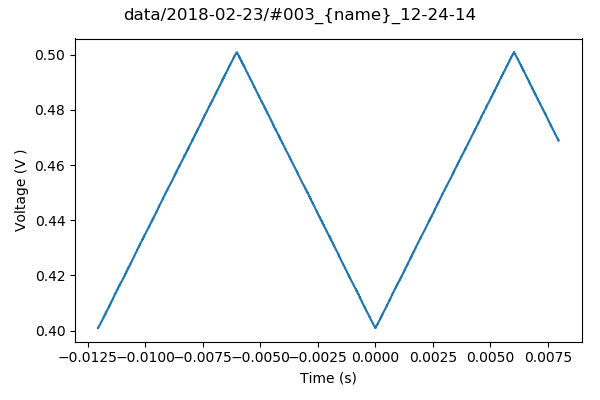

In [7]:
qc.MatPlot(data.lcr3_ch1_curvedata)